In [1]:
import Task
import Solutions
import random
import math
import importlib
import copy
import numpy as np
import statistics
import matplotlib.pyplot as plt
from scipy.stats import erlang, expon

In [2]:
PARETO_SIZE = 100_000
CHUNK_SIZE  =  50_000

# Dozwolone odchylenie od zakladanego wspolczynnika pareto
PARETO_DEVIATION = 0.05

# Dopuszczalna wielkość outlinerów przy modyfikowaniu rozkładu pareto
OUTLINERS_SIZE = 1

# Ilość okresów generowania zadań
TOTAL_CHUNKS = 100

# Minimalna ilość zadań do wykonania
MIN_TASKS = 5000

REPEATS = 6

Rozkład pareto


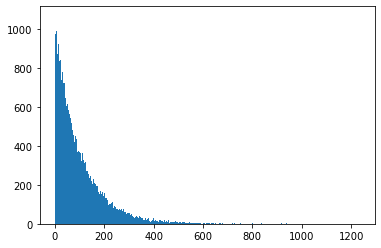

In [3]:
np.random.seed(14)
pareto = np.ceil(np.random.pareto(100, PARETO_SIZE) * 10000)
pareto = pareto[pareto != 0]
plt.hist(pareto, bins=[x for x in range(0, int(max(pareto)) + 10, 1)])
print("Rozkład pareto")

#### Rozkład zadań w chunk (mniejsza szansa na zadanie na początku)

Figures


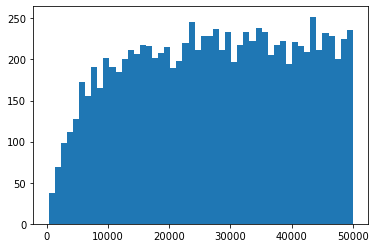

In [4]:
exponential_chunk_internal_values = np.arange(CHUNK_SIZE)
exponential_chunk_internal_chance = expon.cdf(exponential_chunk_internal_values, scale=CHUNK_SIZE/10)
expo = random.choices(exponential_chunk_internal_values, weights=exponential_chunk_internal_chance, k = CHUNK_SIZE)

def begins_in_chunk(num_of):
    return random.choices(exponential_chunk_internal_values, weights=exponential_chunk_internal_chance, k = num_of)


plt.hist(begins_in_chunk(10000), bins=50)

print("Figures")

#### Generowanie gęstości zadań w każdym chunk

In [5]:
def generateSomeDensity(TARGET_PARETO):
    rolled_pareto = []
    for i in range(TOTAL_CHUNKS):
        rolled_pareto.append(int(random.choice(pareto)))

    tasks_var = statistics.variance(rolled_pareto)
    tasks_mean  = 1.0 * statistics.mean(rolled_pareto)
    factor = math.sqrt(tasks_var) / tasks_mean
    
    while abs(factor - TARGET_PARETO) > PARETO_DEVIATION:
        rolled_num = random.randint(0, TOTAL_CHUNKS - 1)
        
        acc = rolled_pareto[rolled_num]
        new = (int(random.choice(pareto)) * OUTLINERS_SIZE) - (OUTLINERS_SIZE - 1)
        rolled_pareto[rolled_num] = new
    
        tasks_var = statistics.variance(rolled_pareto)
        tasks_mean  = 1.0 * statistics.mean(rolled_pareto)
        new_factor = math.sqrt(tasks_var) / tasks_mean
        
        if abs(factor - TARGET_PARETO) <= abs(new_factor - TARGET_PARETO):
            # Cofanie zmian
            rolled_pareto[rolled_num] = acc
        else:
            factor = new_factor

    return rolled_pareto


def generateDensity(TARGET_PARETO):
    rolled = []
    
    while sum([x for x in rolled]) < MIN_TASKS:
        rolled = rolled + generateSomeDensity(TARGET_PARETO)
    
    return rolled

Figures


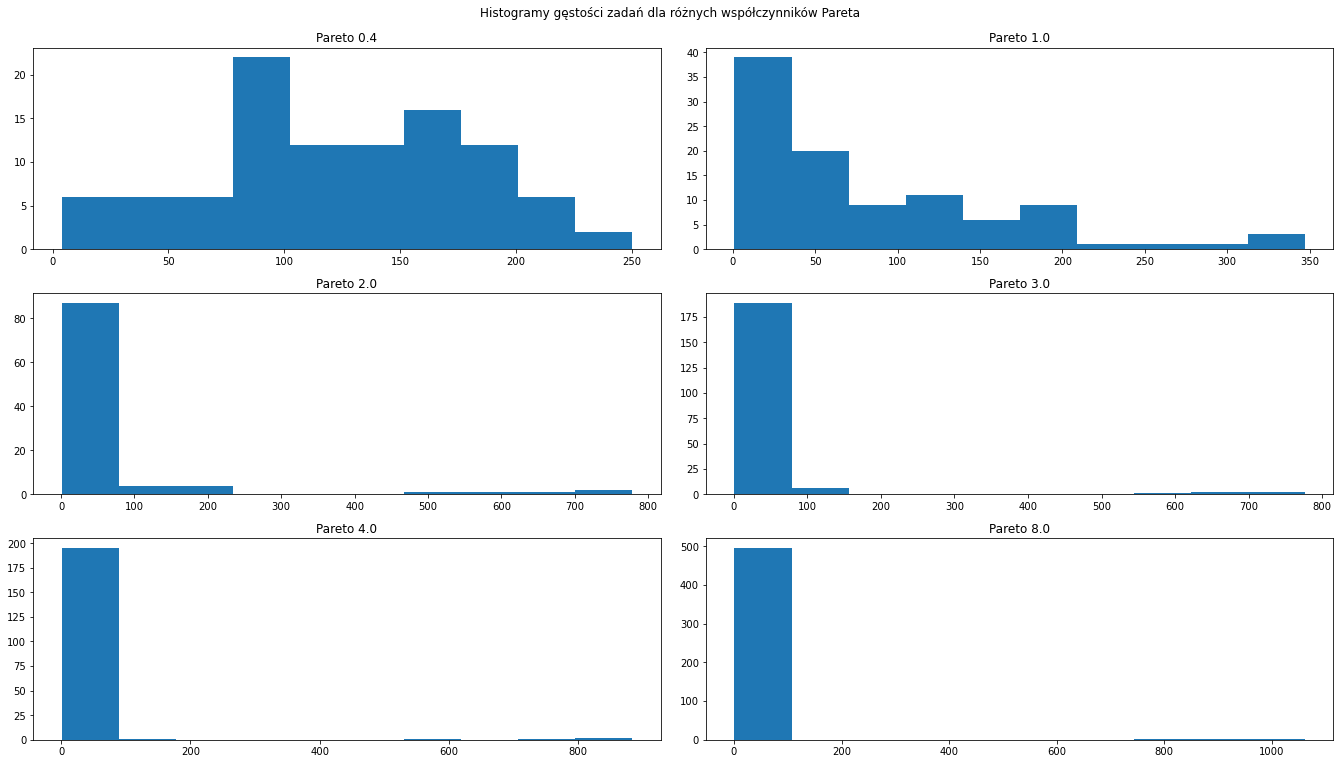

In [6]:
fig, axs = plt.subplots(3, 2, constrained_layout=True)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Histogramy gęstości zadań dla różnych współczynników Pareta')

axs[0][0].hist(generateDensity(0.4))
axs[0][0].set_title('Pareto 0.4')

axs[0][1].hist(generateDensity(1))
axs[0][1].set_title('Pareto 1.0')

axs[1][0].hist(generateDensity(2))
axs[1][0].set_title('Pareto 2.0')

axs[1][1].hist(generateDensity(3))
axs[1][1].set_title('Pareto 3.0')

axs[2][0].hist(generateDensity(4))
axs[2][0].set_title('Pareto 4.0')

axs[2][1].hist(generateDensity(8))
axs[2][1].set_title('Pareto 8.0')

print("Figures")

#### Tworzenie zadań i przypisanie im odpowiedniej długości

In [7]:
def generateTasks(TARGET_AVG_LOAD, TARGET_PARETO, TARGET_MAX_DELAY):
    TASKS = []
    chunk_begin = 0
    density = generateDensity(TARGET_PARETO)
    
    for tasks_in_chunk in density:
        begins = begins_in_chunk(tasks_in_chunk)
        
        # Create Tasks
        for begin in begins:
            task = Task.Task(int(begin + chunk_begin), 0)
            TASKS.append(task)
            
        chunk_begin += CHUNK_SIZE
    
    
    number_of_tasks = len(TASKS)
    processing_duration = max([x.begin for x in TASKS])
    target_avg_size = (TARGET_AVG_LOAD * processing_duration) / number_of_tasks
    durations = np.array(erlang.rvs(math.ceil(target_avg_size), scale = 1,  size = number_of_tasks)).astype(int)

    diff = int(sum(durations) - (number_of_tasks * target_avg_size))
    step = 0
    
    if (diff > 0):
        step = math.ceil(1.0 * diff / 2000.0)
    else:
        step = math.floor(1.0 * diff / 2000.0)
    
    for i in range(0, abs(diff), step):
        durations[i % len(durations)] -= (diff / abs(diff))
        
        if (durations[i % len(durations)] <= 0):
            print("<<<<<<<<<<<<<<<<<< 0")
            return

    for num, task in enumerate(TASKS):
        task.set_duration(int(durations[num]))
    
    
    # Wyswietlenie informacji o wygenerowanych zadaniach
    tasks_var = statistics.variance(density)
    tasks_mean  = 1.0 * statistics.mean(density)
    new_factor = math.sqrt(tasks_var) / tasks_mean
    avg_load = sum([x.duration for x in TASKS]) / (processing_duration * 1.0)
    print("Generowanie zadan..")
    print("Wygenerowano ", number_of_tasks, " zadań")
    print("Współczynnik zmienności: ", new_factor)
    print("Średnie obciążenie: ", avg_load)
    
    for task in TASKS:
        task.set_max_delay(TARGET_MAX_DELAY)
    
    
    TASKS.sort(key = lambda task: task.begin)
    return TASKS

Generowanie zadan..
Wygenerowano  5708  zadań
Współczynnik zmienności:  6.997450829031159
Średnie obciążenie:  0.5002693287808287


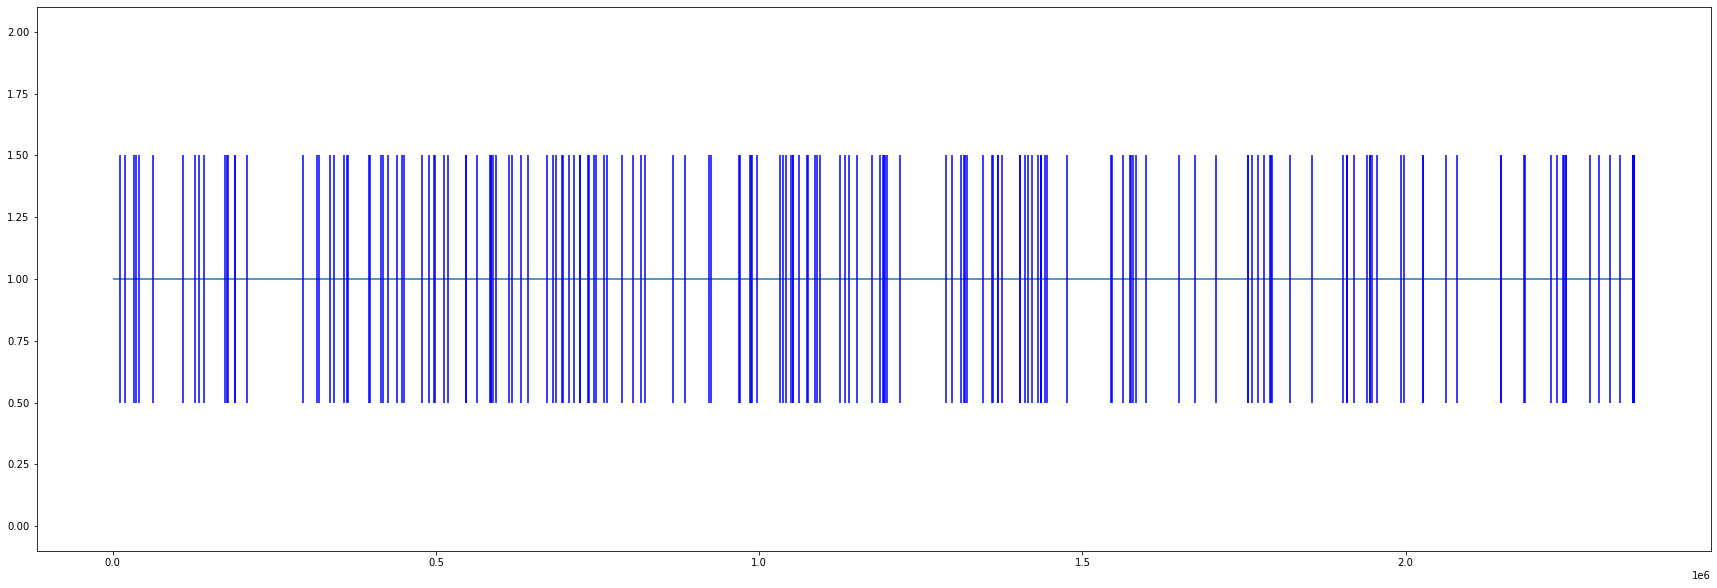

In [22]:
sample_tasks = generateTasks(0.5, 7, 6000)
begins = [int(x.begin) for x in sample_tasks]
begins_sample = begins[:1200]

plt.figure(figsize=(30,10))
plt.hlines(1,1,max(begins_sample))  # Draw a horizontal line
plt.eventplot(begins_sample, orientation='horizontal', colors='b')
plt.axis('on')
plt.show()

#### Zdefiniowanie funkcji do rozwiązywania zadań

In [9]:
def processWithQueue(tasks):
    durations = [int(x.duration) for x in tasks]
    avg_duration = statistics.mean(durations)
    DTmax = max([int(x.max_delay) for x in tasks])
    processor = Solutions.Solutions("QUEUE", avg_duration, DTmax)

    for task in tasks:
        processor.process(task)
    
    processor.finish()
    succeed = sum([task.processing_finished <= task.fdl  for task in tasks])
    
    result = (1.0 * succeed) / len(tasks)
    print("Znaleziono rozwiązania motodą Queue. % zadań wykonanych w czasie: ", result)
    return result



def processWithPS(tasks):
    durations = [int(x.duration) for x in tasks]
    avg_duration = statistics.mean(durations)
    DTmax = max([int(x.max_delay) for x in tasks])
    processor_ps = Solutions.Solutions("PS", avg_duration, DTmax)
    
    for task in tasks:
        processor_ps.process(task)
        
    processor_ps.finish()
    succeed = sum([task.processing_finished <= task.fdl  for task in tasks])
    
    result = (1.0 * succeed) / len(tasks)
    print("Znaleziono rozwiązania motodą PS. % zadań wykonanych w czasie: ", result)
    return result

#### Rozwiązywanie zadań - zmienne średnie obciążenie

In [10]:
# resultsPS = []
# resultsQUEUE = []

# for load in [x * 0.05 for x in range(1, 24)]:
    
#     somePS = []
#     someQUEUE = []
    
#     for ii in range(REPEATS):
#         tasks = generateTasks(load, 3, 1200)

#         tasks_ps = copy.deepcopy(tasks)
#         tasks_queue = copy.deepcopy(tasks)
        
#         somePS.append(processWithPS(tasks_ps))
#         someQUEUE.append(processWithQueue(tasks_queue))
        
#     resultsPS.append(np.mean(somePS))
#     resultsQUEUE.append(np.mean(someQUEUE))
#     print("Wyniki pomiarów:")
#     print(resultsPS)
#     print(resultsQUEUE)
    
# print(resultsPS)
# print(resultsQUEUE)

#### Rozwiązywanie zadań - zmienny współczynnik zmienności

In [11]:
# resultsPS = []
# resultsQUEUE = []

# for factor in [x * 0.3 for x in range(1, 20)]:
    
#     somePS = []
#     someQUEUE = []
    
#     for ii in range(REPEATS):
#         tasks = generateTasks(0.05, factor, 1200)

#         tasks_ps = copy.deepcopy(tasks)
#         tasks_queue = copy.deepcopy(tasks)
        
#         somePS.append(processWithPS(tasks_ps))
#         someQUEUE.append(processWithQueue(tasks_queue))
        
#     resultsPS.append(np.mean(somePS))
#     resultsQUEUE.append(np.mean(someQUEUE))
#     print("Wyniki pomiarów:")
#     print(resultsPS)
#     print(resultsQUEUE)
    
# print(resultsPS)
# print(resultsQUEUE)

### Wyniki

- Średnie obciążenie 0.05
- Współczynnik zmienności od 0.3 do 6.0 z krokiem 0.3
- Maksymalne dopuszczalne opóźnienie : 1200

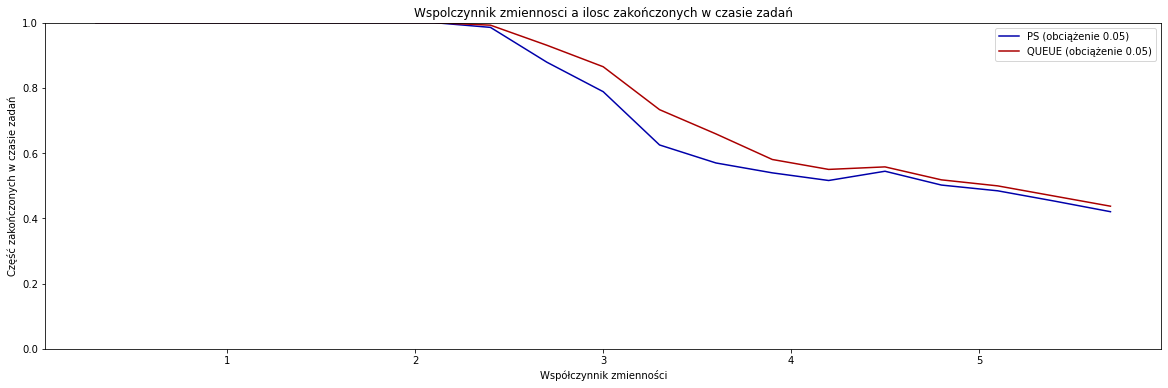

In [12]:
ps_005_1200    = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9854685551007698, 0.8787421398193601, 0.7883166252510259, 0.6249643546676259, 0.569786834253071, 0.5394647924023162, 0.5160119436126295, 0.5443824613338384, 0.5020419417677766, 0.48438032743870246, 0.45305098826258783, 0.42033841891263857]
queue_005_1200 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9922606360945488, 0.9307106347838235, 0.8648010252357871, 0.7331896097045789, 0.6589000838132757, 0.5804318422317973, 0.5499990419186129, 0.5577416822342037, 0.5180149080019236, 0.4994984285032936, 0.4683365134773867, 0.43722202881562067]

plt.rcParams["figure.figsize"] = (20,6)
labels = [x * 0.3 for x in range(1, 20)]

plt.plot(labels, ps_005_1200, label='PS (obciążenie 0.05)', color="#0000AA")
plt.plot(labels, queue_005_1200, label='QUEUE (obciążenie 0.05)', color="#AA0000")

plt.ylabel('Część zakończonych w czasie zadań')
plt.ylim([0,1])
plt.xlabel('Współczynnik zmienności')
plt.title('Wspolczynnik zmiennosci a ilosc zakończonych w czasie zadań')

plt.legend();
plt.show()

- Średnie obciążenie 0.4
- Współczynnik zmienności od 0.3 do 6.0 z krokiem 0.3
- Maksymalne dopuszczalne opóźnienie : 1200

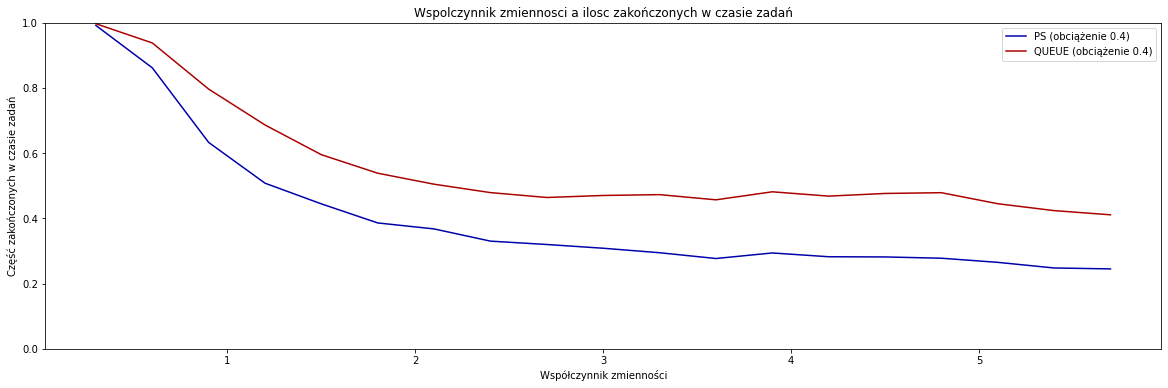

In [13]:
ps_04_1200 = [0.9912970825104717, 0.8614479396595511, 0.6327835221620506, 0.5077764700401542, 0.44433632803850276, 0.3858937215365647, 0.36752781276827035, 0.3300957862449649, 0.31977753121458263, 0.30830423661942785, 0.2945614909980833, 0.2768213307792378, 0.2938607427941814, 0.28224215584632706, 0.2816264496095954, 0.2777250578520397, 0.26504180693085183, 0.24781617283706686, 0.24497705133165545]
queue_04_1200 = [0.996678639118322, 0.9377592150906857, 0.7962833023793834, 0.6862561838141495, 0.5950911748508259, 0.5383487056129532, 0.5046361663277708, 0.47888128571231664, 0.4639073569248855, 0.4700959048765638, 0.4726773428048654, 0.45676896406830547, 0.4813717910327462, 0.468129489619149, 0.47627841262398646, 0.4786234485311063, 0.4447920040081431, 0.42366611783568303, 0.4108453643975468]

plt.rcParams["figure.figsize"] = (20,6)
labels = [x * 0.3 for x in range(1, 20)]

plt.plot(labels, ps_04_1200, label='PS (obciążenie 0.4)', color="#0000AA")
plt.plot(labels, queue_04_1200, label='QUEUE (obciążenie 0.4)', color="#AA0000")

plt.ylabel('Część zakończonych w czasie zadań')
plt.ylim([0,1])
plt.xlabel('Współczynnik zmienności')
plt.title('Wspolczynnik zmiennosci a ilosc zakończonych w czasie zadań')

plt.legend();
plt.show()

- Średnie obciążenie 0.7
- Współczynnik zmienności od 0.3 do 6.0 z krokiem 0.3
- Maksymalne dopuszczalne opóźnienie : 1200

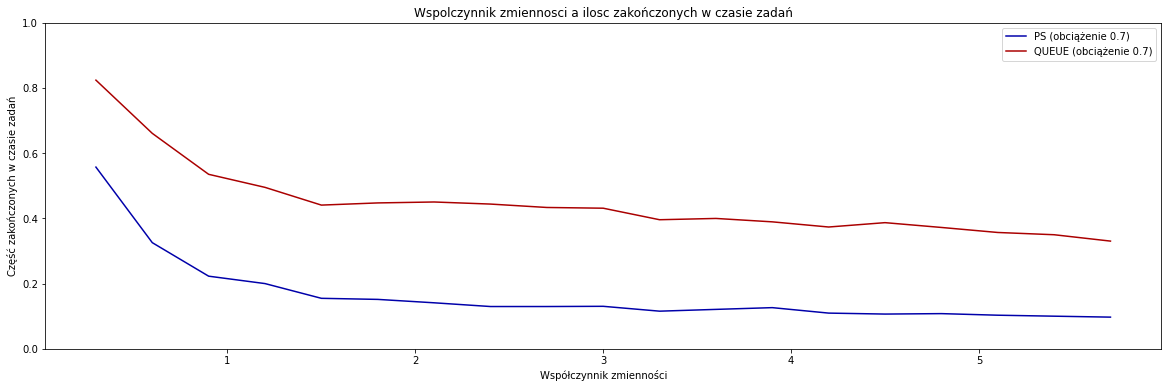

In [14]:
ps_07_1200 = [0.557084830488684, 0.3254264744856215, 0.22265839991454114, 0.19995231215579934, 0.15477985516299533, 0.15148692222411236, 0.14103453059743007, 0.12960826273648293, 0.12960491562583423, 0.13026176142933632, 0.11537997488127658, 0.12084028784688186, 0.12618237981316752, 0.10944182927449427, 0.10649755874090809, 0.10784421819249809, 0.10299907033391228, 0.10000260862681679, 0.097093598328537]
queue_07_1200 = [0.823697020019359, 0.6605273440609989, 0.5349715575523952, 0.4949546872107643, 0.4405816304985673, 0.4472633547206823, 0.4501262835138829, 0.4437231134517754, 0.43331048908244857, 0.4310716966828882, 0.39573094978905804, 0.3996805923933051, 0.3892364923917014, 0.3734041428909275, 0.3867487067274265, 0.3720556210611572, 0.3566435476390169, 0.3497309427472588, 0.3301959921059264]

plt.rcParams["figure.figsize"] = (20,6)
labels = [x * 0.3 for x in range(1, 20)]

plt.plot(labels, ps_07_1200, label='PS (obciążenie 0.7)', color="#0000AA")
plt.plot(labels, queue_07_1200, label='QUEUE (obciążenie 0.7)', color="#AA0000")

plt.ylabel('Część zakończonych w czasie zadań')
plt.ylim([0,1])
plt.xlabel('Współczynnik zmienności')
plt.title('Wspolczynnik zmiennosci a ilosc zakończonych w czasie zadań')

plt.legend();
plt.show()

- Średnie obciążenie od 0.05 do 0.95 z krokiem 0.05
- Współczynnik zmienności 0.5
- Maksymalne dopuszczalne opóźnienie : 6000

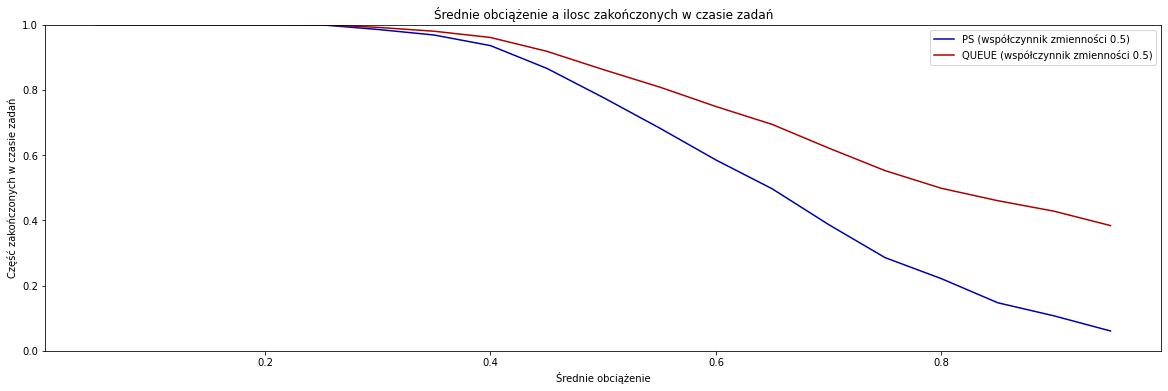

In [15]:
ps_05_6000 = [1.0, 1.0, 1.0, 0.9998900212625559, 0.9993491711117984, 0.9852488668485888, 0.9681984958475406, 0.9356853211320291, 0.8658984236707739, 0.77661595404273, 0.683024408066353, 0.5850930171908182, 0.4965198050463431, 0.38698580017102185, 0.2857413557852887, 0.2211910926999862, 0.14731148795547688, 0.10707051811737593, 0.060828769680471316]
queue_05_6000 = [1.0, 1.0, 1.0, 0.9999193489258744, 0.9996463505056503, 0.9916706067542507, 0.9797917584049408, 0.9606339027368762, 0.9182097694266123, 0.8622284396654395, 0.8086674931435194, 0.7489921784237208, 0.693995486943512, 0.6215961590723171, 0.5524695394884078, 0.49825927304990614, 0.4602353282993003, 0.42796247234349655, 0.3839174673646384]

plt.rcParams["figure.figsize"] = (20,6)
labels = [x * 0.05 for x in range(1, 20)]

plt.plot(labels, ps_05_6000, label='PS (współczynnik zmienności 0.5)', color="#0000AA")
plt.plot(labels, queue_05_6000, label='QUEUE (współczynnik zmienności 0.5)', color="#AA0000")

plt.ylabel('Część zakończonych w czasie zadań')
plt.ylim([0,1])
plt.xlabel('Średnie obciążenie')
plt.title('Średnie obciążenie a ilosc zakończonych w czasie zadań')

plt.legend();
plt.show()

- Średnie obciążenie od 0.05 do 0.95 z krokiem 0.05
- Współczynnik zmienności 2
- Maksymalne dopuszczalne opóźnienie : 6000

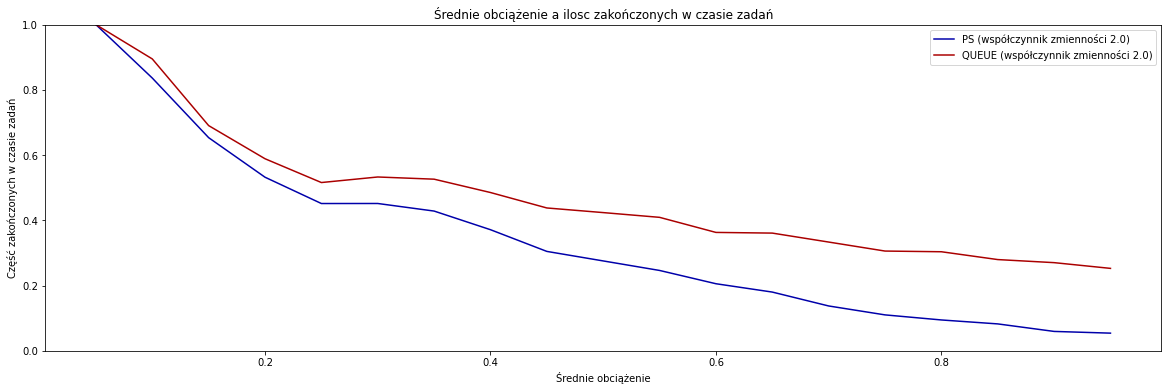

In [16]:
ps_20_6000 = [1.0, 0.8362358480090416, 0.6534748972110573, 0.5322127133474538, 0.45154636464475806, 0.45165050566231607, 0.4284213097982022, 0.3712871450329284, 0.30474269422163863, 0.27554404237910834, 0.24635166271449896, 0.20563490098980827, 0.18006396059970262, 0.13747253222334077, 0.1101184942464097, 0.09455535589291127, 0.0824714683656885, 0.0594157892082597, 0.05413377306404116]
queue_20_6000 = [1.0, 0.894838933901241, 0.690442644982695, 0.5888453149478455, 0.5158872350417829, 0.5329029059716238, 0.5261869181749745, 0.48527150573971223, 0.43793538882829425, 0.4237394415906208, 0.4091845352555164, 0.36296276337423816, 0.3608731702710044, 0.3334173842780702, 0.30580485909611455, 0.30368897036171033, 0.27970201286036533, 0.27027228718643964, 0.25271185821395775]

plt.rcParams["figure.figsize"] = (20,6)
labels = [x * 0.05 for x in range(1, 20)]

plt.plot(labels, ps_20_6000, label='PS (współczynnik zmienności 2.0)', color="#0000AA")
plt.plot(labels, queue_20_6000, label='QUEUE (współczynnik zmienności 2.0)', color="#AA0000")

plt.ylabel('Część zakończonych w czasie zadań')
plt.ylim([0,1])
plt.xlabel('Średnie obciążenie')
plt.title('Średnie obciążenie a ilosc zakończonych w czasie zadań')

plt.legend();
plt.show()

- Średnie obciążenie od 0.05 do 0.95 z krokiem 0.05
- Współczynnik zmienności 6
- Maksymalne dopuszczalne opóźnienie : 6000

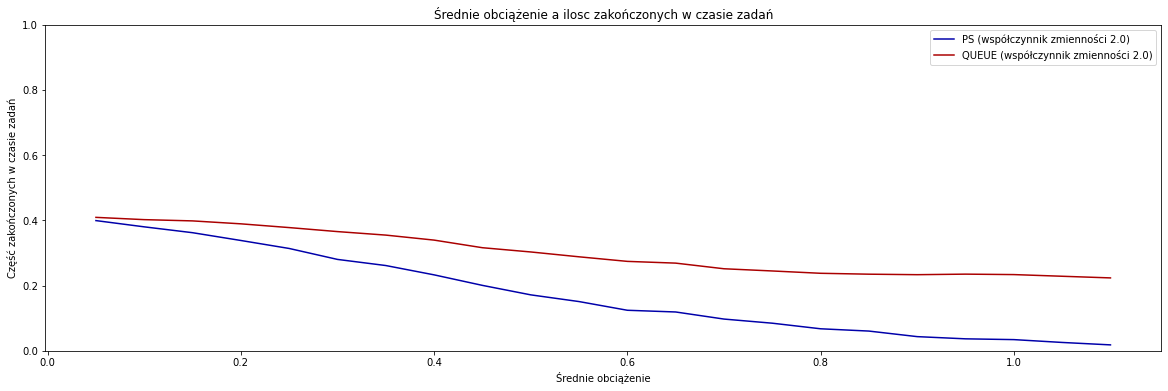

In [17]:
ps_20_6000 = [0.39920706908713244, 0.380039722876519, 0.36209413888064856, 0.3382361200719112, 0.31374161318322363, 0.28018172289559634, 0.26141527131386777, 0.2328470707977154, 0.2005669377686802, 0.1715277058794968, 0.1509427090970418, 0.12427437229116176, 0.1190203201124653, 0.09729743342425609, 0.08462287303625007, 0.06750566434927421, 0.06048576281455409, 0.04344539541814868, 0.03669772976013533, 0.03429834306025362, 0.025604219076715333, 0.01814494822455302]
queue_20_6000 = [0.4091133624466953, 0.40213127153148465, 0.39827592025747205, 0.389276393144979, 0.3777821802789991, 0.3654880381177735, 0.3547299291746811, 0.33937580395456035, 0.3160522969770974, 0.3030387772528267, 0.2881752372297738, 0.2741686268721909, 0.26881458607790476, 0.25153458249558136, 0.2447661244120994, 0.23764805912982317, 0.23489254372145293, 0.23337262110833965, 0.23504049104346417, 0.23366527236638465, 0.22854146443387777, 0.22348870906981927]
plt.rcParams["figure.figsize"] = (20,6)
labels = [x * 0.05 for x in range(1, 23)]

plt.plot(labels, ps_20_6000, label='PS (współczynnik zmienności 2.0)', color="#0000AA")
plt.plot(labels, queue_20_6000, label='QUEUE (współczynnik zmienności 2.0)', color="#AA0000")

plt.ylabel('Część zakończonych w czasie zadań')
plt.ylim([0,1])
plt.xlabel('Średnie obciążenie')
plt.title('Średnie obciążenie a ilosc zakończonych w czasie zadań')

plt.legend();
plt.show()

- Średnie obciążenie od 0.05 do 0.95 z krokiem 0.05
- Współczynnik zmienności 0.5
- Maksymalne dopuszczalne opóźnienie : 1200

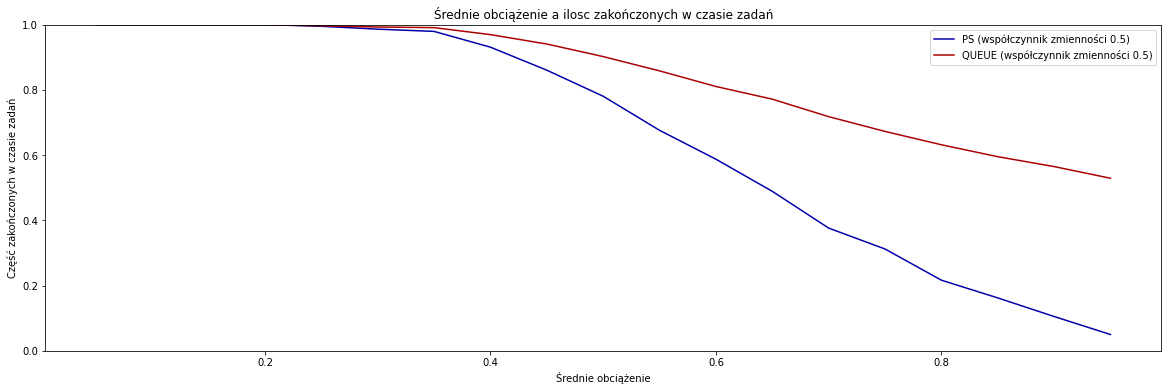

In [18]:
ps_05_1200 = [1.0, 1.0, 0.9998246453052765, 1.0, 0.9949522043947105, 0.9861344875038915, 0.9792309279530794, 0.9308713527231814, 0.8603367814177169, 0.7804161807690763, 0.6760035549487956, 0.5874367942136163, 0.4889336793049964, 0.3762408266893072, 0.31211521891163313, 0.21651104677320623, 0.16218311321043086, 0.10515677160362595, 0.04993529487742256]
queue_05_1200 = [1.0, 1.0, 0.9999202933205803, 1.0, 0.9965016346037727, 0.9927783116227357, 0.9908382939110177, 0.9694058016873421, 0.9405764987489059, 0.9020689106724065, 0.8582350027137033, 0.8103725993136088, 0.7715271135235399, 0.7178851949250923, 0.6726399333563826, 0.6316749488139493, 0.595139533255655, 0.5648393031407595, 0.5290699370834645]

plt.rcParams["figure.figsize"] = (20,6)
labels = [x * 0.05 for x in range(1, 20)]

plt.plot(labels, ps_05_1200, label='PS (współczynnik zmienności 0.5)', color="#0000AA")
plt.plot(labels, queue_05_1200, label='QUEUE (współczynnik zmienności 0.5)', color="#AA0000")

plt.ylabel('Część zakończonych w czasie zadań')
plt.ylim([0,1])
plt.xlabel('Średnie obciążenie')
plt.title('Średnie obciążenie a ilosc zakończonych w czasie zadań')

plt.legend();
plt.show()

- Średnie obciążenie od 0.05 do 1.0 z krokiem 0.05
- Współczynnik zmienności 2.0
- Maksymalne dopuszczalne opóźnienie : 1200

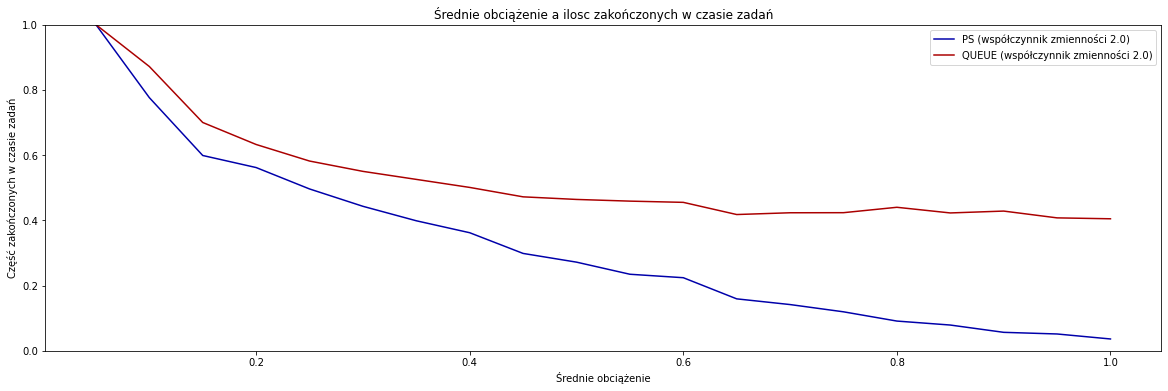

In [19]:
ps_20_1200 = [1.0, 0.7762345693435487, 0.5988274193004135, 0.5618608973309357, 0.4962421678074464, 0.44303128947186365, 0.3986544383042253, 0.36201126907403774, 0.2985235587414662, 0.2718197495052719, 0.2346949103658081, 0.22409265384768934, 0.15926760210568372, 0.14177270463663474, 0.11953249175888336, 0.09116371396058212, 0.07898152219581071, 0.05661052537460927, 0.05157543276613709, 0.03625813949459668]
queue_20_1200 = [1.0, 0.8716487008636552, 0.7000194999288845, 0.6325595209211043, 0.5818212003143687, 0.5501314987482269, 0.5255242783519484, 0.5009093976189158, 0.47203253580484245, 0.46407244050514757, 0.45889165179168395, 0.45512555365705304, 0.4177945620553484, 0.42321061976738894, 0.4234609784546775, 0.44001272750327214, 0.4226722435684268, 0.4283865945074711, 0.4075521758874773, 0.40476913973740675]

plt.rcParams["figure.figsize"] = (20,6)
labels = [x * 0.05 for x in range(1, 21)]

plt.plot(labels, ps_20_1200, label='PS (współczynnik zmienności 2.0)', color="#0000AA")
plt.plot(labels, queue_20_1200, label='QUEUE (współczynnik zmienności 2.0)', color="#AA0000")

plt.ylabel('Część zakończonych w czasie zadań')
plt.ylim([0,1])
plt.xlabel('Średnie obciążenie')
plt.title('Średnie obciążenie a ilosc zakończonych w czasie zadań')

plt.legend();
plt.show()

- Średnie obciążenie od 0.05 do 1.1 z krokiem 0.05
- Współczynnik zmienności 6.0
- Maksymalne dopuszczalne opóźnienie : 1200

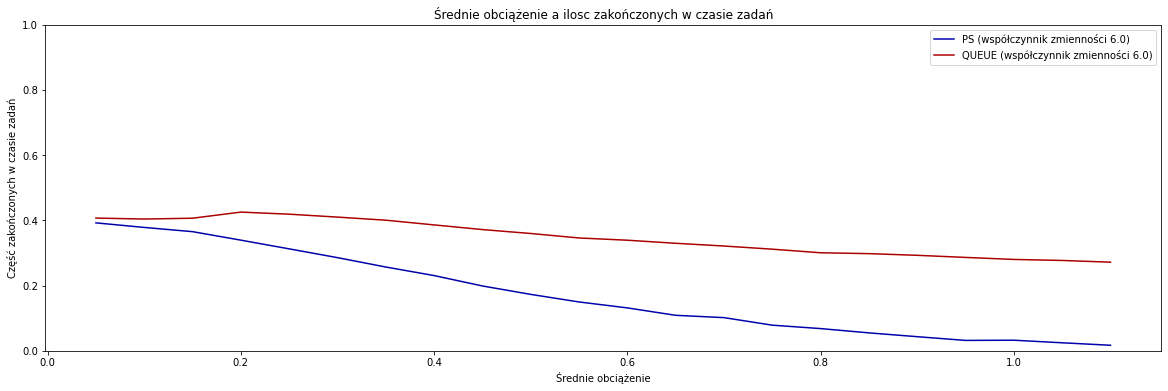

In [20]:
ps_60_1200 = [0.39223735842634416, 0.3782320203064011, 0.3652765549762826, 0.3392537949934366, 0.31252095043022493, 0.28561055219934695, 0.2568677348297998, 0.23068801933831856, 0.19878633063624018, 0.1729535404857395, 0.14974794897336038, 0.1315382992634153, 0.10880598289250179, 0.10170207631592913, 0.07858081861317079, 0.0680998218782786, 0.054967139978158275, 0.043262370661451055, 0.03185924002663755, 0.03246856690246523, 0.024555911502730853, 0.016987069574118045]
queue_60_1200 = [0.4069256129921178, 0.4039785354310058, 0.40651775857574035, 0.4252782001011937, 0.41885197819332287, 0.4099154711355375, 0.4004343668485843, 0.3859767916885142, 0.3716984477257459, 0.3596658282756112, 0.34594874235779216, 0.3390440638651827, 0.3296426337215955, 0.3212426529213588, 0.3115901928790363, 0.30053824542319274, 0.297884948107383, 0.2927697000329167, 0.2862871777424198, 0.28010985448571457, 0.276997456739478, 0.27169435831599703]

plt.rcParams["figure.figsize"] = (20,6)
labels = [x * 0.05 for x in range(1, 23)]

plt.plot(labels, ps_60_1200, label='PS (współczynnik zmienności 6.0)', color="#0000AA")
plt.plot(labels, queue_60_1200, label='QUEUE (współczynnik zmienności 6.0)', color="#AA0000")

plt.ylabel('Część zakończonych w czasie zadań')
plt.ylim([0,1])
plt.xlabel('Średnie obciążenie')
plt.title('Średnie obciążenie a ilosc zakończonych w czasie zadań')

plt.legend();
plt.show()